In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
from itertools import product
from tqdm import tqdm

# hw4 - recommendations

## Реализуйте метрики

А именно precision@k и recall@k.

Значения метрик будем считать для k = 10.

Метрики я для удобства считаю на месте

## Content-based рекомендации

### Подготовка тестовых данных

[Качать отсюдава](https://www.kaggle.com/rounakbanik/the-movies-dataset) + вы можете использовать любой датасет с фильмами
___
На основе таблицы "ratings_small" отберите для каждого пользователя тестовую выборку фильмов (того, что он уже посмотрел).
Предлагается взять последние 3-5 фильмов (по "timestamp").

In [2]:
links = pd.read_csv('links.csv', low_memory=False)
links.drop(np.where(links.tmdbId.isna())[0], inplace=True)
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
45838,176269,6209470,439050.0
45839,176271,2028550,111109.0
45840,176273,303758,67758.0
45841,176275,8536,227506.0


In [3]:
data = pd.read_csv('movies_metadata.csv', low_memory=False).drop([19730, 29503, 35587])
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
data['id'] = data['id'].astype('int')
data = data.merge(credits, on='id')
data = data.merge(keywords, on='id')
data = data[data['vote_count']>=5]
data['overview'] = data['overview'].fillna('')
data = data.drop_duplicates(subset=['id'])
data

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46613,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 14, 'nam...",NaN,106807,tt0135571,fr,Nouvelles luttes extravagantes,A series of fantastical wrestling matches.,...,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,NaN,The Fat and Lean Wrestling Match,False,6.5,6.0,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '52fe4a71c3a36847f81ce35b', 'de...","[{'id': 5970, 'name': 'wrestling'}, {'id': 607..."
46615,False,NaN,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,404604,tt5690142,hi,Maa,The bliss of a biology teacher’s family life i...,...,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,NaN,Mom,False,6.6,14.0,"[{'cast_id': 1, 'character': 'Devki Sabarwal',...","[{'credit_id': '58ee55bbc3a3683df500bd0f', 'de...","[{'id': 155794, 'name': 'physical abuse'}, {'i..."
46618,False,NaN,0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",NaN,84419,tt0038621,en,House of Horrors,An unsuccessful sculptor saves a madman named ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Meet...The CREEPER!,House of Horrors,False,6.3,8.0,"[{'cast_id': 5, 'character': 'The Creeper', 'c...","[{'credit_id': '58152c139251415a7f0047e2', 'de...","[{'id': 9748, 'name': 'revenge'}, {'id': 9826,..."
46622,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,30840,tt0102797,en,

In [4]:
def get_tmdb(movieId):
    if len(links[links.movieId==movieId])==0:
        return -1
    return int(links[links.movieId==movieId].tmdbId.iloc[0])
def get_movie(tmdbId):
    if tmdbId<0:
        return []
    if len(data[data.id == tmdbId])==0:
        return []
    return data[data.id == tmdbId]
get_movie(get_tmdb(1))

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."


In [5]:
ind_map = data[['id', 'title']]
ind_map.index = ind_map.title
ind_map = pd.Series(ind_map.id)
ind_map

title
Toy Story                              862
Jumanji                               8844
Grumpier Old Men                     15602
Waiting to Exhale                    31357
Father of the Bride Part II          11862
                                     ...  
The Fat and Lean Wrestling Match    106807
Mom                                 404604
House of Horrors                     84419
Robin Hood                           30840
Betrayal                             67758
Name: id, Length: 30879, dtype: int32

In [6]:
rating = pd.read_csv('ratings_small.csv', low_memory=False)
n_users = rating.userId.max()
rating

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [7]:
# remove unmatched movie links
unmatched = []
for i in tqdm(range(len(rating))):
    if len(get_movie(get_tmdb(rating.iloc[i].movieId)))==0:
        unmatched.append(i)
rating.drop(unmatched, inplace=True)

100%|█████████████████████████████████████████████████████████████████████████| 100004/100004 [02:56<00:00, 565.55it/s]


In [8]:
rating

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [9]:
rating.to_csv('rating_fixed.csv', index = False)

In [6]:
rating = pd.read_csv('rating_fixed.csv', low_memory=False)
rating

,0,1,2,3,4,5,6,7,8,9
0,-0.808461,0.569618,-0.028623,-0.293919,0.283801,-0.296227,-0.188683,0.828857,0.472696,0.388508
1,-0.446299,-0.242423,-0.317879,-0.810742,0.062455,-0.061084,-0.001293,0.886556,0.646952,-0.300738
2,-0.524922,0.843636,0.154028,0.151949,-0.535688,0.421928,-0.221550,-0.042551,0.061885,-0.014787
3,0.375725,1.028082,0.077216,0.279745,-0.461859,0.272889,0.068996,0.045003,0.066054,-0.007117
4,-0.657839,0.551281,0.073232,0.133431,0.130839,-0.142258,-0.037389,-0.016358,-0.113994,-0.005058
...,...,...,...,...,...,...,...,...,...,...
30874,-0.731098,0.515324,0.060314,-0.059509,0.163917,-0.175544,0.117113,0.142880,0.076061,-0.008153
30875,0.693867,-0.507534,0.136106,0.760110,0.210057,-0.235498,-0.507192,0.046665,0.353381,0.045581
30876,-0.365645,-0.978165,0.948073,0.465399,-0.075658,0.077060,0.182696,0.124918,0.153818,-0.300031
30877,0.648389,0.047753,-0.628731,0.062561,-0.751602,0.508739,0.101185,-0.231351,-0.061663,0.047884


In [13]:
train = []
for i in range(n_users):
    user = []
    for line in rating[rating.userId == i+1].iloc:
        user.append([line.movieId, line.rating, line.timestamp])
    train.append(pd.DataFrame(user, columns=['movie','rating','time']).astype({'movie':int, 'rating':float,'time':int}))
train = np.array(train,dtype=object)

In [14]:
rating_train = [train[i].sort_values('time').iloc[:-5] for i in range(n_users)]
rating_test = [train[i].sort_values('time').iloc[-5:] for i in range(n_users)]

In [15]:
rating_train[0], rating_test[0]

(    movie  rating        time
 16   2294     2.0  1260759108
 17   2455     2.5  1260759113
 19   3671     3.0  1260759117
 8    1339     3.5  1260759125
 9    1343     2.0  1260759131
 10   1371     2.5  1260759135
 13   2105     4.0  1260759139
 0      31     2.5  1260759144
 7    1293     2.0  1260759148
 5    1263     2.0  1260759151
 1    1029     3.0  1260759179
 2    1061     3.0  1260759182
 3    1129     2.0  1260759185
 6    1287     2.0  1260759187
 12   1953     4.0  1260759191,
     movie  rating        time
 14   2150     3.0  1260759194
 15   2193     2.0  1260759198
 18   2968     1.0  1260759200
 11   1405     1.0  1260759203
 4    1172     4.0  1260759205)

In [16]:
'Минимум фильмов на пользователя в train: '+str(np.array([rating_train[i].shape[0] for i in range(n_users)]).min())

'Минимум фильмов на пользователя в train: 14'

### Векторное представление данных [20%]

Для датасета с фильмами подготовьте векторное представление фильмов по векторам TF-IDF и по другим параметрам, например, можно взять [отсюда](https://www.datacamp.com/community/tutorials/recommender-systems-python)!

$$WeightedRating=(\frac{v}{v+m}⋅R)+(\frac{m}{v+m}⋅C)$$

где:
- v (votes) число оценок фильма;

- m (minimum) минимальное число оценок для попадания в топ;

- R (rating) средний рейтинг фильма;

- C (across) средний рейтинг по всем фильмам.

In [7]:
def weighted_rating(x, q=.9):
    v = x['vote_count']
    m = v.quantile(q)
    R = x['vote_average']
    C = R.mean()
    return (v/(v+m)*R) + (m/(v+m)*C)
data['score'] = weighted_rating(data, .95)

In [8]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(data['overview'])
#Output the shape of tfidf_matrix
tfidf_matrix.shape

(30879, 59767)

In [18]:
tfidf.get_feature_names()[20000:20010]

['franc',
 'franca',
 'france',
 'francella',
 'frances',
 'francesa',
 'francesca',
 'francesco',
 'franchise',
 'franchises']

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
cosine_sim_tfidf = cosine_similarity(tfidf_matrix,tfidf_matrix)

In [21]:
cosine_sim_tfidf[0][:100]

array([1.        , 0.01511083, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03889508, 0.        , 0.        ,
       0.00960742, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01861795, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00646029, 0.        , 0.        , 0.00883166, 0.        ,
       0.        , 0.        , 0.01307914, 0.01057175, 0.        ,
       0.        , 0.01984486, 0.02529103, 0.02044355, 0.03263308,
       0.        , 0.        , 0.00803666, 0.        , 0.00987363,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [9]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    data[feature] = data[feature].apply(literal_eval)

In [10]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan
def get_producers(x):
    l = []
    for i in x:
        if i['department'] == 'Production':
            l.append(i['name'])
    if len(l) > 3:
        l = l[:3]
    return l
def get_story(x):
    l = []
    for i in x:
        if i['department'] == 'Writing':
            l.append(i['name'])
    if len(l) > 5:
        l = l[:5]
    return l
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [11]:
data['director'] = data['crew'].apply(get_director)
data['producers'] = data['crew'].apply(get_producers)
data['story'] = data['crew'].apply(get_story)

features = ['cast', 'keywords', 'genres']
for feature in features:
    data[feature] = data[feature].apply(get_list)

In [12]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'producers', 'story', 'genres']
for feature in features:
    data[feature] = data[feature].apply(clean_data)

In [13]:
# Director is joined thrice to increase his/her weight relative to producers
def join(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + ' '.join([x['director']] * 3) + ' ' + ' '.join(x['producers']) + ' ' + ' '.join(x['genres']) + ' ' + ' '.join(x['story'])

In [14]:
data['keys'] = data.apply(join, axis=1)

In [15]:
data = data.reset_index()
data

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,vote_average,vote_count,cast,crew,keywords,score,director,producers,story,keys
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",7.514641,johnlasseter,"[bonniearnold, edcatmull, ralphguggenheim]","[josswhedon, andrewstanton, joelcohen, alecsok...",jealousy toy boy tomhanks timallen donrickles ...
1,1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,...,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbook]",6.717062,joejohnston,"[larryj.franco, nancyfoy, scottkroopf]","[jonathanhensleigh, chrisvanallsburg, gregtayl...",boardgame disappearance basedonchildren'sbook ...
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,...,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, bestfriend, duringcreditsstinger]",6.138144,howarddeutch,[],"[markstevenjohnson, markstevenjohnson]",fishing bestfriend duringcreditsstinger walter...
3,3,False,NaN,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,en,Waiting to Exhale,...,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",6.091340,forestwhitaker,"[ronaldbass, ezraswerdlow, deborahschindler]","[ronaldbass, terrymcmillan, terrymcmillan]",basedonnovel interracialrelationship singlemot...
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,...,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlifecrisis, confidence]",6.013896,charlesshyer,[nancymeyers],"[nancymeyers, alberthackett]",baby midlifecrisis confidence stevemartin dian...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30874,46613,False,NaN,0,"[comedy, fantasy]",NaN,106807,tt0135571,fr,Nouvelles luttes extravagantes,...,6.5,6.0,"[jeanned'alcy, georgesméliès]","[{'credit_id': '52fe4a71c3a36847f81ce35b', 'de...","[wrestling, sport, silentfilm]",6.094375,georgesméliès,[],[],wrestling sport silentfilm jeanned'alcy george...
30875,46615,False,NaN,0,"[crime, drama, thriller]",NaN,404604,tt5690142,hi,Maa,...,6.6,14.0,"[sridevikapoor, sajalali, akshayekhanna]","[{'credit_id': '58ee55bbc3a3683df500bd0f', 'de...","[physicalabuse, sexualassault]",6.100835,raviudyawar,"[boneykapoor, mukeshtalreja, sunilmanchanda]","[raviudyawar, girishkohli, konavenkatrao]",physicalabuse sexualassault sridevikapoor saja...
30876,46618,False,NaN,0,"[horror, mystery, thriller]",NaN,84419,tt0038621,en,House of Horrors,...,6.3,8.0,"[rondohatton, robertlowery, virginiagrey]","[{'credit_id': '58152c139251415a7f0047e2', 'de...","[revenge, murder, serialkiller]",6.093269,jeanyarbrough,[benpivar],"[georgebricker, dwightv.babcock]",revenge murder serialkiller rondohatton robert...
30877,46622,False,NaN,0,"[drama, action, romance]",NaN,30840,tt0102797,en,Robin Hood,...,5.7,26.0,"[patrickbergin, umathurman, davidmorrissey]","[{'credit_id': '52fe44439251416c9100a899', 'de...",[],6.077018,johnirvin,"[sarahradclyffe, susiefiggis]","[samresnick, johnmcgrath, samresnick]",patrickbergin umathurman davidmorrissey johni...


In [22]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data['keys'])
count_matrix.shape

(30879, 84493)

In [23]:
cosine_sim_count = cosine_similarity(count_matrix,count_matrix)

In [24]:
cosine_sim_count[0][:100]

array([1.        , 0.03402069, 0.03768892, 0.03340766, 0.03857584,
       0.        , 0.03340766, 0.        , 0.        , 0.        ,
       0.03402069, 0.02635231, 0.06933752, 0.        , 0.        ,
       0.        , 0.        , 0.02988072, 0.03227486, 0.03768892,
       0.03686049, 0.        , 0.        , 0.        , 0.        ,
       0.03608439, 0.07372098, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03077287, 0.        , 0.        ,
       0.08333333, 0.03340766, 0.        , 0.        , 0.        ,
       0.03857584, 0.        , 0.03608439, 0.        , 0.        ,
       0.03686049, 0.        , 0.        , 0.02988072, 0.        ,
       0.03402069, 0.        , 0.03282661, 0.03608439, 0.03768892,
       0.        , 0.03608439, 0.03340766, 0.03857584, 0.03857584,
       0.        , 0.04564355, 0.02988072, 0.03952847, 0.        ,
       0.        , 0.03031695, 0.        , 0.        , 0.08838835,
       0.        , 0.        , 0.        , 0.04166667, 0.     

In [16]:
# Get recommendations based on cosine sim
def get_recommendations(title, cosine_sim):
    # Get the index of the movie that matches the title
    idx = get_movie(ind_map[title])
    if len(idx)==0:
        return idx
    idx = idx.index[0]
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return data['title'].iloc[movie_indices]

In [35]:
print('The Lord of the Rings\n', get_recommendations('The Lord of the Rings: The Fellowship of the Ring', cosine_sim_tfidf))
print('Toy Story\n', get_recommendations('Toy Story', cosine_sim_tfidf))
print('Your Name.\n', get_recommendations('Your Name.', cosine_sim_tfidf))

The Lord of the Rings
 1713                             The Lord of the Rings
7772                                        The Hobbit
16443                The Hobbit: An Unexpected Journey
17848              The Hobbit: The Desolation of Smaug
14047                           The Return of the King
6188     The Lord of the Rings: The Return of the King
18516                                             Wolf
22348                                   A Fighting Man
5127             The Lord of the Rings: The Two Towers
29367                                        Priceless
Name: title, dtype: object
Toy Story
 13359               Toy Story 3
2602                Toy Story 2
9099     The 40 Year Old Virgin
19426                 Small Fry
7356                  The Champ
902       Rebel Without a Cause
1639                  Condorman
10096    For Your Consideration
25234             Lost and Love
2654            Man on the Moon
Name: title, dtype: object
Your Name.
 11502                        A

In [36]:
print('The Lord of the Rings\n', get_recommendations('The Lord of the Rings: The Fellowship of the Ring', cosine_sim_count))
print('Toy Story\n', get_recommendations('Toy Story', cosine_sim_count))
print('Your Name.\n', get_recommendations('Your Name.', cosine_sim_count))

The Lord of the Rings
 5127             The Lord of the Rings: The Two Towers
6188     The Lord of the Rings: The Return of the King
19969        The Hobbit: The Battle of the Five Armies
16443                The Hobbit: An Unexpected Journey
17848              The Hobbit: The Desolation of Smaug
9363                                         King Kong
1017                                         Bad Taste
659                                    The Frighteners
3945                                  Meet the Feebles
12711                                 The Lovely Bones
Name: title, dtype: object
Toy Story
 15867                     Tin Toy
15899                 Red's Dream
2602                  Toy Story 2
9419                     Luxo Jr.
15931                 Knick Knack
14712                      Cars 2
9715                         Cars
18373    Mater and the Ghostlight
1925                 A Bug's Life
17768        Toy Story of Terror!
Name: title, dtype: object
Your Name.
 14369    S

In [25]:
# Combine both sets of features
matrix = sparse.hstack([tfidf_matrix, count_matrix])

In [26]:
cosine_sim_avg = cosine_similarity(matrix,matrix)

In [39]:
print('The Lord of the Rings\n', get_recommendations('The Lord of the Rings: The Fellowship of the Ring', cosine_sim_avg))
print('Toy Story\n', get_recommendations('Toy Story', cosine_sim_avg))
print('Your Name.\n', get_recommendations('Your Name.', cosine_sim_avg))

The Lord of the Rings
 6188     The Lord of the Rings: The Return of the King
5127             The Lord of the Rings: The Two Towers
19969        The Hobbit: The Battle of the Five Armies
16443                The Hobbit: An Unexpected Journey
17848              The Hobbit: The Desolation of Smaug
9363                                         King Kong
1017                                         Bad Taste
659                                    The Frighteners
3945                                  Meet the Feebles
12711                                 The Lovely Bones
Name: title, dtype: object
Toy Story
 15899                 Red's Dream
15867                     Tin Toy
2602                  Toy Story 2
9419                     Luxo Jr.
15931                 Knick Knack
9715                         Cars
14712                      Cars 2
1925                 A Bug's Life
18373    Mater and the Ghostlight
13359                 Toy Story 3
Name: title, dtype: object
Your Name.
 14369    S

### Реализуйте рекомендательную систему на основе подхода кластеризации [20%]

Можете выбрать любой алгоритм кластеризации, из расказанных на лекции

In [40]:
matrix.shape

(30879, 144260)

In [41]:
np_matrix = np.array(matrix.toarray(), dtype='float32')

In [42]:
np_matrix.shape

(30879, 144260)

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [44]:
%%time
pca = PCA(n_components=10, random_state=42)
principalComponents = pca.fit_transform(np_matrix)
PCA_components = pd.DataFrame(principalComponents)

Wall time: 5min 53s


In [50]:
PCA_components.to_csv('pca.csv', index = False)

In [57]:
PCA_components = pd.read_csv('pca.csv', low_memory = False)
PCA_components.columns = PCA_components.columns.astype(int)

In [333]:
DBSCAN_df = PCA_components.copy()
clustering = DBSCAN(eps=.1, min_samples=5).fit(DBSCAN_df)
DBSCAN_df.insert(0, 'cluster', clustering.labels_)

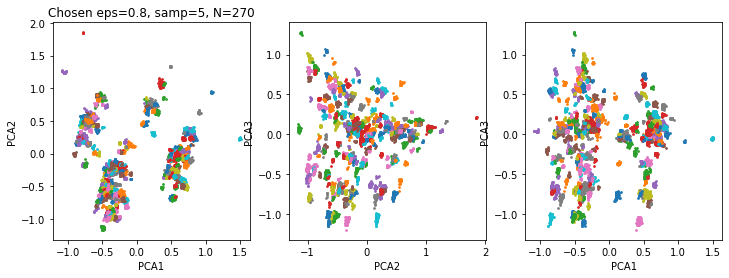

In [334]:
n_clust = len(set(clustering.labels_))
fig,ax = plt.subplots(1,3, figsize=(12, 4))

ax[0].set_title(f'Chosen eps=0.1, samp=5, N={DBSCAN_df.cluster.max()}')

for c in range(DBSCAN_df.cluster.max()+1):
    ax[0].scatter(DBSCAN_df[DBSCAN_df['cluster']==c][0], DBSCAN_df[DBSCAN_df['cluster']==c][1], s=3)
ax[0].set(xlabel='PCA1')
ax[0].set(ylabel='PCA2')

for c in range(DBSCAN_df.cluster.max()+1):
    ax[1].scatter(DBSCAN_df[DBSCAN_df['cluster']==c][1], DBSCAN_df[DBSCAN_df['cluster']==c][2], s=3)
ax[1].set(xlabel='PCA2')
ax[1].set(ylabel='PCA3')

for c in range(DBSCAN_df.cluster.max()+1):
    ax[2].scatter(DBSCAN_df[DBSCAN_df['cluster']==c][0], DBSCAN_df[DBSCAN_df['cluster']==c][2], s=3)
ax[2].set(xlabel='PCA1')
ax[2].set(ylabel='PCA3');

In [335]:
print('misclust',DBSCAN_df.cluster.value_counts()[-1])
DBSCAN_df.cluster.value_counts()

misclust 970


11     3877
4      2542
14     1480
53     1450
37     1364
       ... 
260       5
168       5
267       5
129       5
227       5
Name: cluster, Length: 272, dtype: int64

### Сделайте визуализацию классов [10%]

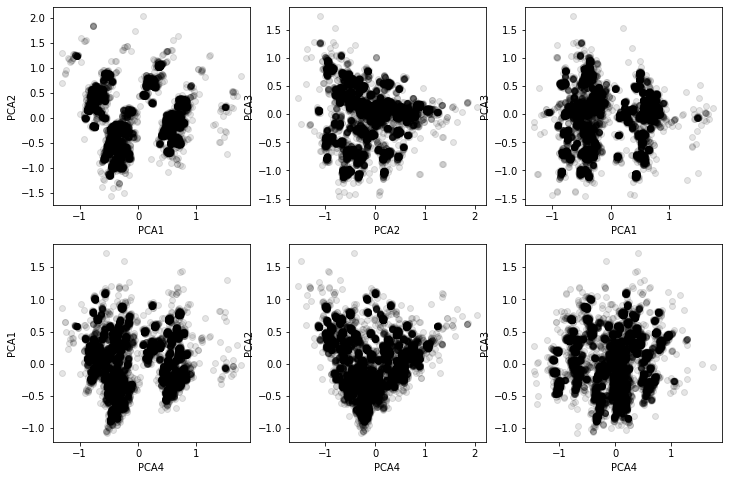

In [318]:
features = range(pca.n_components_)

fig,ax = plt.subplots(2,3, figsize=(12, 8))

ax[0][0].scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
ax[0][0].set(xlabel='PCA1')
ax[0][0].set(ylabel='PCA2')

ax[0][1].scatter(PCA_components[1], PCA_components[2], alpha=.1, color='black')
ax[0][1].set(xlabel='PCA2')
ax[0][1].set(ylabel='PCA3')

ax[0][2].scatter(PCA_components[0], PCA_components[2], alpha=.1, color='black')
ax[0][2].set(xlabel='PCA1')
ax[0][2].set(ylabel='PCA3')

ax[1][0].scatter(PCA_components[0], PCA_components[3], alpha=.1, color='black')
ax[1][0].set(xlabel='PCA4')
ax[1][0].set(ylabel='PCA1')

ax[1][1].scatter(PCA_components[1], PCA_components[3], alpha=.1, color='black')
ax[1][1].set(xlabel='PCA4')
ax[1][1].set(ylabel='PCA2')

ax[1][2].scatter(PCA_components[2], PCA_components[3], alpha=.1, color='black')
ax[1][2].set(xlabel='PCA4')
ax[1][2].set(ylabel='PCA3')

plt.show()

Text(0, 0.5, 'variance %')

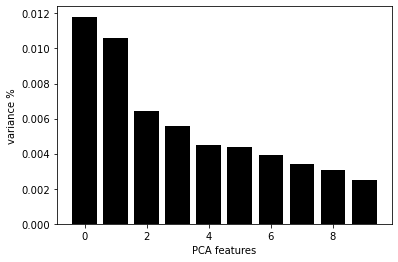

In [138]:
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')

20it [01:50,  5.53s/it]


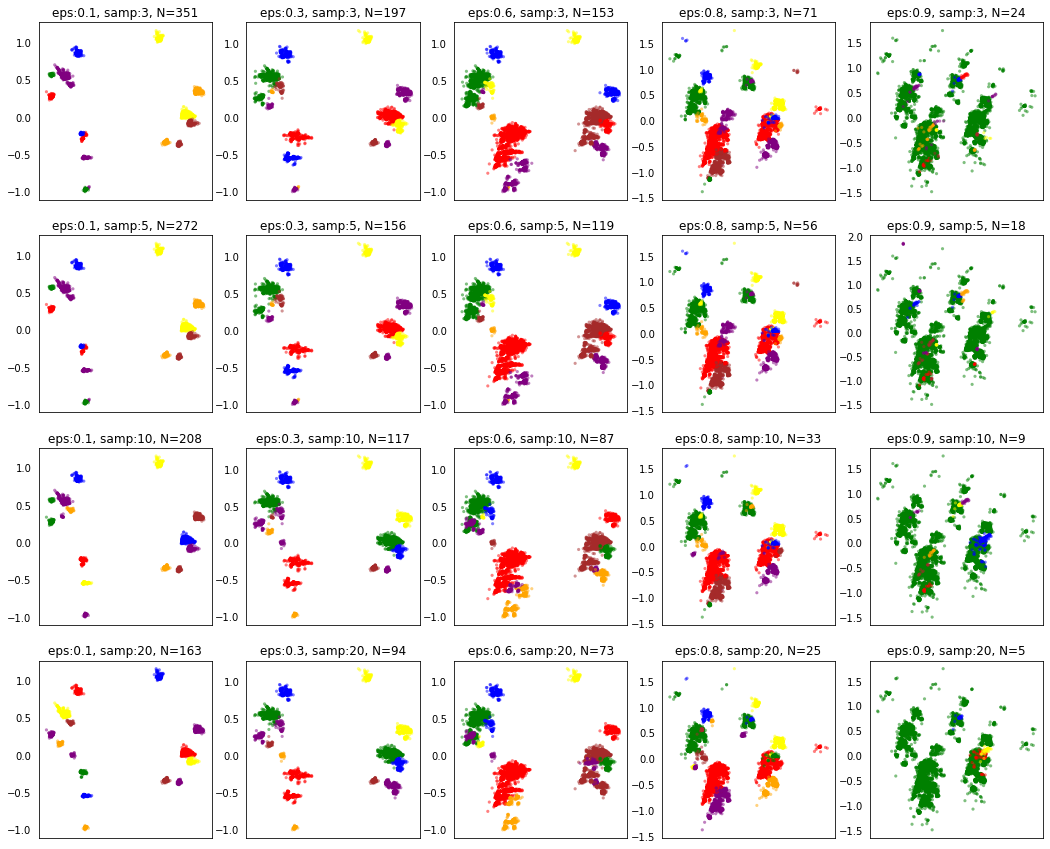

In [85]:
samp_list = [3, 5, 10, 20]
eps_list = [.1, .3, .6, .8, .9]
rows = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(18, 15))

for k, (eps, samp) in tqdm(enumerate(product(eps_list, samp_list))):
    ax[k%rows][k//rows].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False) 

    DBSCAN_df = PCA_components.copy()
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(DBSCAN_df)
    DBSCAN_df.insert(0, 'cluster', clustering.labels_)

    datas = [[DBSCAN_df[DBSCAN_df['cluster']==i][j] for j in range(2)] for i in range(len(set(clustering.labels_)))]
    colors = ('green','red','blue','yellow','purple','brown','orange','purple')*2
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data_,color,group in zip(datas,colors,groups):
        ax[k%rows][k//rows].scatter(data_[0],data_[1], alpha=0.5, c=color, edgecolors='none', s=10, label=group)
        ax[k%rows][k//rows].set_title(f'eps:{eps}, samp:{samp}, N={len(set(clustering.labels_))}')

### Сделайте рекомендацию пользователю [10%]

На основе понравившихся пользователю фильмов определите в какой (какие) кластер он попал и предскажите для него k лучших фильмов

In [319]:
# Get recommendations based on particular cluster
def get_recommendations_cluster(cluster):
    # Get indexes that match cluster
    cluster_idx = DBSCAN_df[DBSCAN_df['cluster']==cluster].index
    return data.iloc[cluster_idx]

In [336]:
cluster_chosen_vote = [0 for i in range(n_users)]
cluster_chosen_freq = [0 for i in range(n_users)]
cluster_chosen_sum = [0 for i in range(n_users)]
for ind in tqdm(range(n_users)):
    clusters_count = [0 for i in range(n_clust)]
    clusters_sum = [0 for i in range(n_clust)]
    for i in range(rating_train[ind].shape[0]):
        if get_tmdb(rating_train[ind].movie.iloc[i]) in data['id'].values:
            cl = int(DBSCAN_df.iloc[get_movie(get_tmdb(rating_train[ind].movie.iloc[i])).index[0]].cluster)
            if cl >= 0:
                clusters_count[cl] += 1
                clusters_sum[cl] += rating_train[ind].rating.iloc[i]
    res = np.array(clusters_sum)
    res[np.array(clusters_count)>0] /= np.array(clusters_count)[np.array(clusters_count)>0]
    cluster_chosen_vote[ind] = res.argmax()
    cluster_chosen_freq[ind] = np.argmax(clusters_sum)
    cluster_chosen_sum[ind] = np.argmax(res + np.array(clusters_sum))
cluster_chosen_vote = np.array(cluster_chosen_vote)
cluster_chosen_freq = np.array(cluster_chosen_freq)
cluster_chosen_sum = np.array(cluster_chosen_sum)

100%|████████████████████████████████████████████████████████████████████████████████| 671/671 [04:26<00:00,  2.52it/s]


### Оцените точность работы вашей системы

In [358]:
s = 0
s_n = 0
for ind in tqdm(range(n_users)):
    for i in range(5):
        films = get_recommendations_cluster(cluster_chosen_sum[ind]).sort_values('score')['id']
        if get_tmdb(rating_test[ind].movie.iloc[i]) in films.drop(films.index[np.where(films.isin(rating_train[ind].movie.apply(get_tmdb).values))[0]])[-10:].values:
            s += rating_test[ind].rating.iloc[i]
            s_n += 1

print("Средняя оценка по всем", s / (n_users*5))
print("Средняя оценка по верно предсказанным", s / s_n)
print("Число верно предсказанных", s_n)
print("precision: ", s_n / (n_users*10))
print("recall: ", s_n / (n_users*5))

100%|████████████████████████████████████████████████████████████████████████████████| 671/671 [07:09<00:00,  1.56it/s]

Средняя оценка по всем 0.06035767511177347
Средняя оценка по верно предсказанным 4.21875
Число верно предсказанных 48
precision:  0.007153502235469449
recall:  0.014307004470938897


In [363]:
s = 0
s_n = 0
for ind in tqdm(range(n_users)):
    for i in range(5):
        films1 = get_recommendations_cluster(cluster_chosen_vote[ind]).sort_values('score')['id']
        films2 = get_recommendations_cluster(cluster_chosen_freq[ind]).sort_values('score')['id']
        films = pd.concat([films1.drop(films1.index[np.where(films1.isin(rating_train[ind].movie.apply(get_tmdb).values))[0]])[-5:],\
                           films2.drop(films2.index[np.where(films2.isin(rating_train[ind].movie.apply(get_tmdb).values))[0]])[-5:]])
        if get_tmdb(rating_test[ind].movie.iloc[i]) in films.values:
            s += rating_test[ind].rating.iloc[i]
            s_n += 1
print("Средняя оценка по всем", s / (n_users*5))
print("Средняя оценка по верно предсказанным", s / s_n)
print("Число верно предсказанных", s_n)
print("precision: ", s_n / (n_users*10))
print("recall: ", s_n / (n_users*5))

100%|████████████████████████████████████████████████████████████████████████████████| 671/671 [13:58<00:00,  1.25s/it]

Средняя оценка по всем 0.05856929955290611
Средняя оценка по верно предсказанным 4.271739130434782
Число верно предсказанных 46
precision:  0.006855439642324888
recall:  0.013710879284649776


### Оцените применимость подхода кластеризации [5%]

На сколько эффективен данный подход

Верхняя оценка точности рекомендации зависит порядком от количества классов, на которые происходит разбиение, отнесенных к общему количеству фильмов - мы не сможем предсказать разбиение на отдельные фильмы внутри класса, если оно там необходимо  
Также сложно определить, что делать с пользователями, попадающими примерно равномерно в несколько классов фильмов (нет разбиения на классы пользователей)

### Предложите улучшения вашей системы [+10% к ДЗ]

Необходимое условие для получения доп баллов:
- Предложить и обосновать число рекомендуемых фильмов
- Обосновать выбор дополнительных параметров для кластеризации
- Обосновать выбор алгоритма кластеризации
- Предложить улучшения для рекомендации пользователю
___
или
- Сделать все пункты задания хорошо

***
Число рекомендуемых фильмов предлагается топ5 фильмов из класса наиболее просмотренных + топ5 фильмов из класса наиболее оцененных  
Параметры кластеризации выбираются из:
 - в классе не должно быть меньше фильмов, чем нужно предсказать  
 - классы не должны быть сильно дисбалансными  
 - классов должно быть достаточное количество  
 
Выбор алгоритма производится по принципу качества соблюдения этих параметров  
В качестве улучшения можно рассмотреть дополнительный отбор фильмов из выбранного класса в отношении конкретного пользователя (например попарно через матрицу сходства фильмов из класса с фильмами, просмотренными пользователем) 

### Сделайте рекомендацию для себя [+20% к ДЗ]

- Добавьте в выборку свои любимые фильмы
- Добавьте себя как пользователя и проставьте рейтинги
- Получите рекомендации

Для получения доп балла нужно посмотреть рекомендуемые фильмы.



In [377]:
# моя рекомендация
my_train = [120, 49051, 603, 157336, 24428, 365942, 286217, 49047, 372058, 10515, 8392, 81, 7453, 129, 869, 11, 1895, 557, 1726, 1858]
my_train_vote = [4., 3., 4.5, 5., 4., 3.5, 3., 2., 5., 2.5, 4.5, 3.5, 3., 4., 3., 5, 3.5, 4., 4.5, 3.5]

In [383]:
for i in range(len(my_train)):
    if (len(get_movie(my_train[i]))>0):
        print(get_movie(my_train[i]).title.iloc[0], my_train_vote[i])

The Lord of the Rings: The Fellowship of the Ring 4.0
The Hobbit: An Unexpected Journey 3.0
The Matrix 4.5
Interstellar 5.0
The Avengers 4.0
The Space Between Us 3.5
The Martian 3.0
Gravity 2.0
Your Name. 5.0
Castle in the Sky 2.5
My Neighbor Totoro 4.5
Nausicaä of the Valley of the Wind 3.5
The Hitchhiker's Guide to the Galaxy 3.0
Spirited Away 4.0
Planet of the Apes 3.0
Star Wars 5
Star Wars: Episode III - Revenge of the Sith 3.5
Spider-Man 4.0
Iron Man 4.5
Transformers 3.5


In [384]:
clusters_count = [0 for i in range(n_clust)]
clusters_sum = [0 for i in range(n_clust)]
for i in range(len(my_train)):
    if my_train[i] in data['id'].values:
        cl = int(DBSCAN_df.iloc[get_movie(my_train[i]).index[0]].cluster)
        if cl >= 0:
            clusters_count[cl] += 1
            clusters_sum[cl] += my_train_vote[i]
res = np.array(clusters_sum)
res[np.array(clusters_count)>0] /= np.array(clusters_count)[np.array(clusters_count)>0]
print('most voted cluster', res.argmax())
print('most watched cluster', np.argmax(clusters_sum))
print('summarily', np.argmax(res+clusters_sum))

most voted cluster 31
most watched cluster 60
summarily 60


In [385]:
cluster1 = 31
cluster2 = 60
movies1 = get_recommendations_cluster(cluster1)
movies2 = get_recommendations_cluster(cluster2)
pd.concat([movies1.drop(movies1.index[np.where(movies1.id.isin(my_train))[0]]).sort_values('score')[-5:],\
           movies2.drop(movies2.index[np.where(movies2.id.isin(my_train))[0]]).sort_values('score')[-5:]]).sort_values('score').title

18693                                   Lucy
16093                                  Dredd
918                     Escape from New York
7003                                I, Robot
20674           Star Wars: The Force Awakens
18763                       Edge of Tomorrow
18499    Captain America: The Winter Soldier
974                       Return of the Jedi
18936                Guardians of the Galaxy
961                  The Empire Strikes Back
Name: title, dtype: object

In [386]:
# рекомендация независимого эксперта
my_train = [13363, 145247, 637, 70, 55420, 13971, 9788, 4951, 771, 10314, 11452, 81188, 673, 82702, 628, 285, 166426, 411, 10140]
my_train_vote = [3.5, 3.5, 5., 1., 4., 4., 4.5, 5., 5., 4.5, 4.5, 5., 4., 4., 3.5, 5., 2., 4., 2.5]

In [387]:
for i in range(len(my_train)):
    if (len(get_movie(my_train[i]))>0):
        print(get_movie(my_train[i]).title.iloc[0], my_train_vote[i])

The Man from Earth 3.5
The 100 Year-Old Man Who Climbed Out the Window and Disappeared 3.5
Life Is Beautiful 5.0
Million Dollar Baby 1.0
Another Earth 4.0
Wild Child 4.0
Accepted 4.5
10 Things I Hate About You 5.0
Home Alone 5.0
She's All That 4.5
National Lampoon’s Van Wilder 4.5
Rise of the Guardians 5.0
Harry Potter and the Prisoner of Azkaban 4.0
How to Train Your Dragon 2 4.0
Interview with the Vampire 3.5
Pirates of the Caribbean: At World's End 5.0
Pirates of the Caribbean: Dead Men Tell No Tales 2.0
The Chronicles of Narnia: The Lion, the Witch and the Wardrobe 4.0
The Chronicles of Narnia: The Voyage of the Dawn Treader 2.5


In [388]:
clusters_count = [0 for i in range(n_clust)]
clusters_sum = [0 for i in range(n_clust)]
for i in range(len(my_train)):
    if my_train[i] in data['id'].values:
        cl = int(DBSCAN_df.iloc[get_movie(my_train[i]).index[0]].cluster)
        if cl >= 0:
            clusters_count[cl] += 1
            clusters_sum[cl] += my_train_vote[i]
res = np.array(clusters_sum)
res[np.array(clusters_count)>0] /= np.array(clusters_count)[np.array(clusters_count)>0]
print('most voted cluster', res.argmax())
print('most watched cluster', np.argmax(clusters_sum))
print('summarily', np.argmax(res+clusters_sum))

most voted cluster 3
most watched cluster 108
summarily 108


In [389]:
cluster1 = 3
cluster2 = 108
movies1 = get_recommendations_cluster(cluster1)
movies2 = get_recommendations_cluster(cluster2)
pd.concat([movies1.drop(movies1.index[np.where(movies1.id.isin(my_train))[0]]).sort_values('score')[-5:],\
           movies2.drop(movies2.index[np.where(movies2.id.isin(my_train))[0]]).sort_values('score')[-5:]]).sort_values('score').title

12878                                             3 Idiots
993                                             Annie Hall
15795                                     Moonrise Kingdom
18694                           X-Men: Days of Future Past
5642     Pirates of the Caribbean: The Curse of the Bla...
9106                           Dilwale Dulhania Le Jayenge
5127                 The Lord of the Rings: The Two Towers
4277     The Lord of the Rings: The Fellowship of the Ring
6188         The Lord of the Rings: The Return of the King
313                                           Forrest Gump
Name: title, dtype: object

In [348]:
import pandas as pd
import numpy as np
import csv
import scipy.sparse as sparse
from IPython.display import display, clear_output
import ctypes

## Collaborative filtering

### Подготовка тестовых данных

[Качать отсюдава](http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html) + вы можете использовать любой датасет с музыкой
___
Прорядите данные по пользователям, чтобы вы могли работь с минимум 1000 пользователей. 

Предлагается:
- Откладывать для теста данные с самым свежим временем прослушивания.
- Отбрасывать старые данные.
- Агрегировать прослушивания по исполнителям и рекоменовать исполнителя.


In [234]:
csv.field_size_limit(int(ctypes.c_ulong(-1).value // 2))
def getline(filename):
    with open(filename, "r", encoding='utf-8') as csvfile:
        datareader = csv.reader(csvfile, delimiter='\t')
        yield next(datareader)  # yield the header row
        for row in datareader:
            yield row

In [ ]:
%%time
all_data = pd.DataFrame()
user_data = pd.DataFrame()
user_data_100 = pd.DataFrame()
user = ''
users_n = 0
user_c = 0
N = 1001
for line in getline('userid-timestamp-artid-artname-traid-traname.tsv'):
    if user != line[0]:
        if users_n != 0:
            user_data_100 = user_data_100.append(user_data).sort_values(1)[-100:]
            all_data = all_data.append(user_data_100)
            clear_output()
            print("n_users =",users_n)
            print("n_cols =",user_data.shape[0])
            if N == users_n:
                break
        user_data = pd.DataFrame(columns=[0,1,2,3])
        user_data_100 = pd.DataFrame(columns=[0,1,2,3])
        user = line[0]
        user_c = 0
        users_n += 1
    if not (line[3] in user_data[2].values):
        user_data = user_data.append(pd.DataFrame([line[0],pd.to_datetime(line[1]),line[3], 1]).T)
        user_c += 1
        if user_data.shape[0] == 500:
            user_data_100 = user_data_100.append(user_data).sort_values(1)[-100:]
            user_data = pd.DataFrame(columns=[0,1,2,3])
            clear_output()
            print("n_users =",users_n)
            print("n_current_cols =",user_c)
    else:
        if pd.to_datetime(line[1]) > user_data[user_data[2] == line[3]].iloc[0,1]:
            user_data.loc[user_data[2] == line[3],1] = pd.to_datetime(line[1])
            user_data.loc[user_data[2] == line[3],3] += 1
    if line[3] in user_data_100[2].values:
        user_data_100.loc[user_data_100[2] == line[3],1] = pd.to_datetime(line[1])
        user_data_100.loc[user_data_100[2] == line[3],3] += 1

n_users = 363
n_current_cols = 1000


In [ ]:
all_data

In [237]:
#all_data.to_csv('transactions100x1000.csv', index=False)

In [315]:
# отобраны 1000 пользователей, для каждого уникальные прослушанные исполнители, топ100 по времени прослушивания
all_data = pd.read_csv('transactions100x1000.csv', low_memory=False)
all_data.columns = ['user','date','author']
all_data

,user,date,author
0,user_000001,2009-03-13 13:11:01+00:00,Scsi-9
1,user_000001,2009-03-15 13:44:21+00:00,To Rococo Rot
2,user_000001,2009-03-17 14:59:51+00:00,Boards Of Canada
3,user_000001,2009-03-25 13:26:26+00:00,Uh Huh Her
4,user_000001,2009-04-01 13:16:15+00:00,Gilles Peterson
...,...,...,...
95885,user_000999,2009-05-04 12:07:37+00:00,System Of A Down
95886,user_000999,2009-05-04 12:16:42+00:00,Nine Inch Nails
95887,user_000999,2009-05-04 12:19:22+00:00,Deftones
95888,user_000999,2009-05-04 12:23:48+00:00,Jaromír Nohavica


In [344]:
user_data = pd.read_csv('userid-profile.tsv', sep = '\t', error_bad_lines=False)

In [345]:
user_data.columns = ['user', 'gender', 'age', 'country', 'registered']
user_data

,user,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"
...,...,...,...,...,...
987,user_000996,f,NaN,United States,"Jul 17, 2006"
988,user_000997,m,NaN,United States,"Jan 5, 2007"
989,user_000998,m,NaN,United Kingdom,"Sep 28, 2005"
990,user_000999,f,NaN,Poland,"Jul 24, 2007"


### Приведите данные к матричному виду


In [316]:
all_data.drop('date', 1, inplace=True)
all_data['user_id'] = all_data['user'].astype("category").cat.codes
all_data['author_id'] = all_data['author'].astype("category").cat.codes
item_lookup_author = all_data[['author_id', 'author']].drop_duplicates()
item_lookup_author['author_id'] = item_lookup_author.author_id.astype(str)
item_lookup_user = all_data[['user_id', 'user']].drop_duplicates()
item_lookup_user['user_id'] = item_lookup_user.user_id.astype(str)
item_lookup_author = item_lookup_author.set_index('author_id')
item_lookup_user = item_lookup_user.set_index('user_id')
item_lookup_author_back = item_lookup_author.copy()
item_lookup_author_back['author_id'] = item_lookup_author_back.index
item_lookup_author_back = item_lookup_author_back.set_index('author')
item_lookup_user_back = item_lookup_user.copy()
item_lookup_user_back['user_id'] = item_lookup_user_back.index
item_lookup_user_back = item_lookup_user_back.set_index('user')
item_lookup_author

,author
author_id,
21580,Scsi-9
26465,To Rococo Rot
3333,Boards Of Canada
27098,Uh Huh Her
9907,Gilles Peterson
...,...
28369,Your Mother
10841,Henry Homesweet
7697,Dzioło


In [338]:
item_lookup_user_back.loc['user_001000'] = int(item_lookup_user_back.values.max())+1

In [347]:
# выставили id в соответствии
user_data['user_id'] = item_lookup_user_back.loc[user_data['user'].values].values
user_data

,user,gender,age,country,registered,user_id
0,user_000001,m,NaN,Japan,"Aug 13, 2006",0
1,user_000002,f,NaN,Peru,"Feb 24, 2006",1
2,user_000003,m,22.0,United States,"Oct 30, 2005",2
3,user_000004,f,NaN,NaN,"Apr 26, 2006",3
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006",4
...,...,...,...,...,...,...
987,user_000996,f,NaN,United States,"Jul 17, 2006",987
988,user_000997,m,NaN,United States,"Jan 5, 2007",988
989,user_000998,m,NaN,United Kingdom,"Sep 28, 2005",989
990,user_000999,f,NaN,Poland,"Jul 24, 2007",990


In [350]:
all_data[['user_id','author_id']]

,user_id,author_id
0,0,21580
1,0,26465
2,0,3333
3,0,27098
4,0,9907
...,...,...
95885,990,23558
95886,990,18047
95887,990,6461
95888,990,12036


In [ ]:
# Превращаем в тип: разреженная матрица
R_sparse = sparse.csr_matrix((plays, (rows, cols)), shape=(len(users), len(artists)))

### Разложите матрицу транзакций на вектора пользователей и исполнителей [25%]

Необходимо реализовать разложение градиентным методом

* Рекомендуется применять [AdamW optimizer](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)
* Сам optimizer реализовывать не нужно

### Сделайте рекомендацию пользователю [10%]


### Оцените точность работы вашей системы